In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [ ]:
tf.compat.v1.enable_eager_execution()
tf.compat.v1.set_random_seed(0)
doggies = tfds.load('stanford_dogs', split='train', as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/stanford_dogs/0.2.0.incompleteRYGN3C/stanford_dogs-train.tfrecord*...:   0%|  …

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/stanford_dogs/0.2.0.incompleteRYGN3C/stanford_dogs-test.tfrecord*...:   0%|   …

Dataset stanford_dogs downloaded and prepared to ~/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


## 0. Flip (Doggie 3)

In [ ]:
def flip_image(image):
  """
  that flips an image horizontally:
  image is a 3D tf.Tensor containing the image to flip
  Returns the flipped image
  """
  return tf.reverse(image, [1])

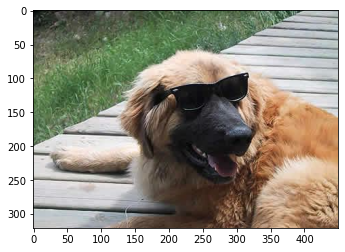

In [ ]:
for i, (image, _) in enumerate(doggies.take(10)):
    if i == 3:
      plt.imshow(flip_image(image))
      plt.show()

## 1. Crop (Doggie 6)

In [ ]:
def crop_image(image, size, offset):
  """performs a random crop of an image:
  image is a 3D tf.Tensor containing the image to crop
  size is a tuple containing the size of the crop
  Returns the cropped image
  """ 
  cropy, cropx, _ = size
  offy, offx = offset
  # Y, X, RGB
  if (cropx + offx > image.shape[1]) or (cropy + offy > image.shape[0]) or (offx < 0) or (offy < 0):
    raise ValueError("crop dimensions are invald. Please choose smaller box or offset")

  return image[offx:cropx + offx, offy:cropy + offy, :]

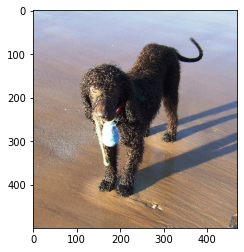

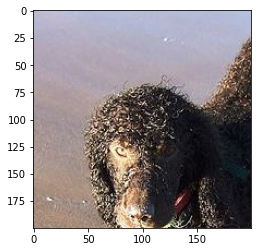

In [ ]:
for i, (image, _) in enumerate(doggies.take(10)):
    if i == 6:
      plt.imshow(image)
      plt.show()
      plt.imshow(crop_image(image, (200, 200, 3), (60, 55)))
      plt.show()

## 2. Rotate

In [ ]:
def rotate_image(image):
  """
  rotates an image by 90 degrees counter-clockwise:
  image is a 3D tf.Tensor containing the image to rotate
  Returns the rotated image
  """
  return tf.image.rot90(image, k=1)

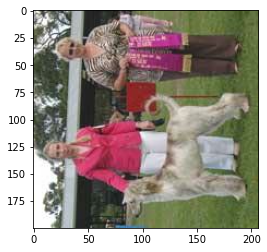

In [ ]:
for i, (image, _) in enumerate(doggies.take(10)):
    if i == 7:
        plt.imshow(rotate_image(image))
        plt.show()

## 3. Shear

In [ ]:
def shear_image(image, intensity):
  """
  randomly shears an image:
  image is a 3D tf.Tensor containing the image to shear
  intensity is the intensity with which the image should be sheared
  Returns the sheared image
  """
  # changing image to format [RGB, Col, Row]
  image = tf.transpose(image, (2, 0, 1))
  # shear
  image = tf.keras.preprocessing.image.random_shear(image, intensity)
  # changing imager back to format [Col, Row, RGB]
  return tf.transpose(image, (1, 2, 0))

(207, 200, 3)
(3, 207, 200)


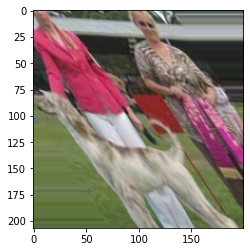

In [ ]:
for i, (image, _) in enumerate(doggies.take(10)):
    if i == 7:
      plt.imshow(shear_image(image, 50))
      plt.show()

## 4. Brightness

In [ ]:
def change_brightness(image, max_delta): 
  """
  randomly changes the brightness of an image:
  image is a 3D tf.Tensor containing the image to change
  max_delta is the maximum amount the image should be brightened (or darkened)
  Returns the altered image
  """
  image = tf.cast(image, tf.int32)
  max_delta = int(round(max_delta * 255, 0))
  print(max_delta)
  # brighten
  if tf.random.uniform([1], minval=0, maxval=1) > 0.5:
    image += tf.random.uniform([1], minval=0, maxval=max_delta, dtype=tf.dtypes.int32)
  # darken
  else:
    image -= tf.random.uniform([1], minval=0, maxval=max_delta, dtype=tf.dtypes.int32)
  return image

76


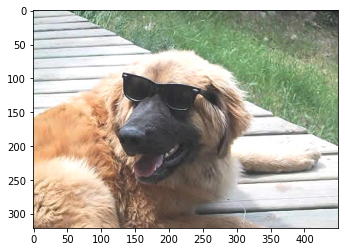

In [ ]:
for i, (image, _) in enumerate(doggies.take(10)):
    if i == 3:
      plt.imshow(change_brightness(image, 0.3))
      plt.show()

##5. Hue

In [ ]:
def change_hue(image, delta):
    """
    that changes the hue of an image
    image is a 3D tf.Tensor containing the image to change
    delta is the amount the hue should change
    Returns the altered image
    """
    return tf.image.adjust_hue(image, delta)

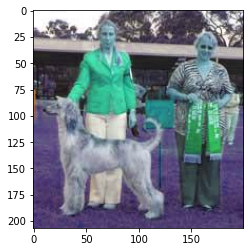

In [ ]:
for i, (image, _) in enumerate(doggies.take(10)):
    if i == 7:
      plt.imshow(change_hue(image, -0.5))
      plt.show()

##7. PCA RGB

In [ ]:
from sklearn.decomposition import PCA
def pca_color(image, alphas):
  """
  performs PCA color augmentation as described in the AlexNet paper:
  image is a 3D tf.Tensor containing the image to change
  alphas a tuple of length 3 containing the amount that each channel should change
  Returns the augmented image
  """
  red = image[:, :, 0]
  green = image[:, :, 1]
  blue = image[:, :, 2]
  df_blue = blue/255
  df_green = green/255
  df_red = red/255

  pca_b = PCA(n_components=50)
  pca_b.fit(df_blue)
  trans_pca_b = pca_b.transform(df_blue)
  pca_g = PCA(n_components=50)
  pca_g.fit(df_green)
  trans_pca_g = pca_g.transform(df_green)
  pca_r = PCA(n_components=50)
  pca_r.fit(df_red)
  trans_pca_r = pca_r.transform(df_red)

  b_arr = pca_b.inverse_transform(trans_pca_b)
  g_arr = pca_g.inverse_transform(trans_pca_g)
  r_arr = pca_r.inverse_transform(trans_pca_r)
  img_reduced= np.stack((b_arr, g_arr, r_arr))
  return image   

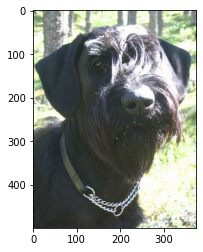

In [ ]:
import numpy as np
np.random.seed(100)
for i, (image, _) in enumerate(doggies.take(10)):
    if i == 2:
      alphas = np.random.normal(0, 0.1, 3)
      plt.imshow(pca_color(image, alphas))
      plt.show()